# Volatility Forecasting using GARCH (1,1)

#### GARCH(1,1) model with t-distributed residuals to Bitcoin-USD (BTC-USD) returns from 2015 to 2024. The model is then used to predict 3-step ahead volatility forecasts for each day in 2024 using three different forecasting methods:

- **Analytical Forecasts**
- **Simulation-Based Forecasts**
- **Bootstrap Forecasts**

#### GARCH(1,1) model can be written as:


 $$ r_t = \mu + \epsilon_t, \quad \epsilon_t = \sigma_t z_t$$ 


where:
- $r_t$ is the asset return at time  t
- $\mu$  is the mean of returns (set to zero in this model)
- $\epsilon_t$  is the error term
- $\sigma_t$ is the conditional volatility (standard deviation of  \epsilon_t )
- $z_t$  is an i.i.d. random variable from a t-distribution (specified in the code)

The conditional variance follows:


$$ \sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$


where:
- $\omega$ is a constant term
- $\alpha$ is the impact of past squared returns $(\epsilon_{t-1}^2)$ on volatility
- $\beta$ is the impact of past volatility $(\sigma_{t-1}^2)$ on current volatility

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
from arch import arch_model

In [2]:
df = yf.download("BTC-USD",
                 start="2015-01-01",
                 end="2024-12-31",
                 actions=True)
returns = 100 * df["Close"].pct_change().dropna()
returns.name = "asset_returns"

[*********************100%***********************]  1 of 1 completed


In [3]:
model = arch_model(returns, mean="Zero", vol="GARCH", dist="t",
                   p=1, q=1)

In [7]:
SPLIT_DATE = datetime(2024, 1, 1)
fitted_model = model.fit(last_obs=SPLIT_DATE, disp="off")

<Axes: xlabel='Date'>

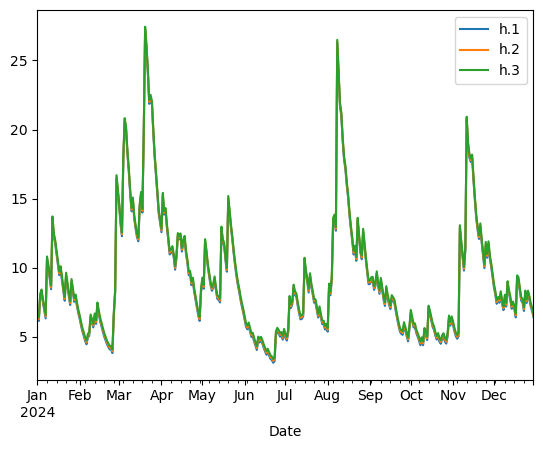

In [9]:
forecasts_analytical = fitted_model.forecast(horizon=3,
                                             start=SPLIT_DATE,
                                         reindex=False)
title="Analytical forecasts for different horizons"
forecasts_analytical.variance.plot(
)

In [11]:
forecasts_analytical.variance

,h.1,h.2,h.3
Date,,,
2024-01-01,6.331375,6.462083,6.592790
2024-01-02,6.150915,6.281623,6.412330
2024-01-03,7.861033,7.991741,8.122449
2024-01-04,8.170762,8.301470,8.432177
2024-01-05,7.488533,7.619240,7.749948
...,...,...,...
2024-12-26,8.083963,8.214671,8.345379
2024-12-27,7.698563,7.829271,7.959979
2024-12-28,7.175191,7.305898,7.436606


<Axes: title={'center': 'Simulation forecasts for different horizons'}, xlabel='Date'>

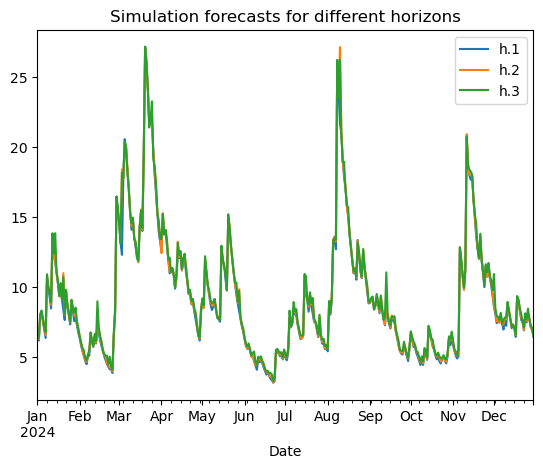

In [13]:
forecasts_simulation = fitted_model.forecast(
    horizon=3,
    start=SPLIT_DATE,
    method="simulation",
    reindex=False
)
forecasts_simulation.variance.plot(
    title="Simulation forecasts for different horizons"
)

<Axes: title={'center': 'Bootstrap forecasts for different horizons'}, xlabel='Date'>

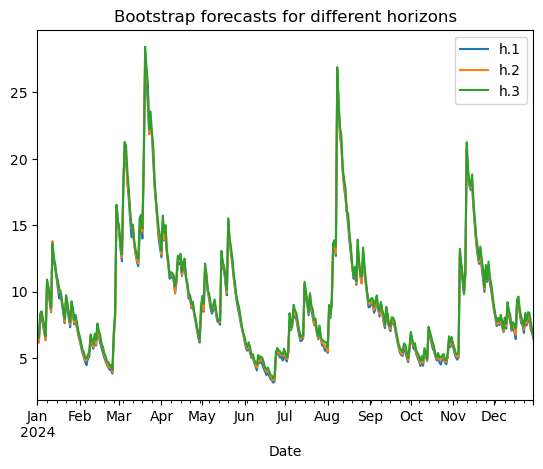

In [15]:
forecasts_bootstrap = fitted_model.forecast(horizon=3,
                                            start=SPLIT_DATE,
                                            method="bootstrap",
                                            reindex=False)
forecasts_bootstrap.variance.plot(
    title="Bootstrap forecasts for different horizons"
)

In [27]:
FCST_HORIZON = 10

vol_analytic = (
    fitted_model.forecast(horizon=FCST_HORIZON,
                          start=datetime(2024, 1, 1),
                          reindex=False)
    .residual_variance.loc["2024-01-01":]  # Filter rows by date
    .apply(np.sqrt)
)

vol_bootstrap = (
    fitted_model.forecast(horizon=FCST_HORIZON,
                          start=datetime(2024, 1, 1),
                          method="bootstrap",
                          reindex=False)
    .residual_variance.loc["2024-01-01":]  # Filter rows by date
    .apply(np.sqrt)
)
vol = fitted_model.conditional_volatility["2024"]

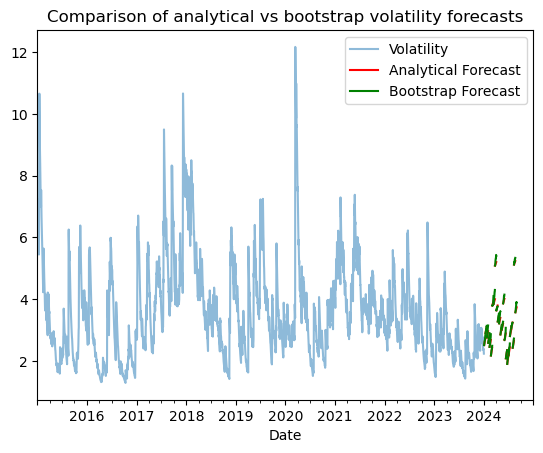

In [36]:
ax = vol.plot(
    title="Comparison of analytical vs bootstrap volatility forecasts",
    alpha=0.5
)
ind = vol.index
for i in range(0, 240, 10):
    vol_a = vol_analytic.iloc[i]
    vol_b = vol_bootstrap.iloc[i]
    start_loc = ind.get_loc(vol_a.name)
    new_ind = ind[(start_loc+1):(start_loc+FCST_HORIZON+1)]
    vol_a.index = new_ind
    vol_b.index = new_ind
    ax.plot(vol_a, color="r")
    ax.plot(vol_b, color="g")
labels = ["Volatility", "Analytical Forecast",
          "Bootstrap Forecast"]
legend = ax.legend(labels)
  

# Add legend
labels = ["Volatility", "Analytical Forecast", "Bootstrap Forecast"]
ax.legend(labels)

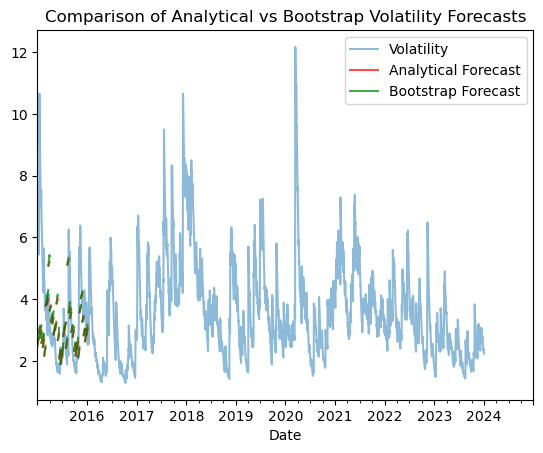

In [32]:
FCST_HORIZON = 10

# Ensure valid date range
vol_analytic = (
    fitted_model.forecast(horizon=FCST_HORIZON, start=datetime(2024, 1, 1))
    .residual_variance
    .apply(np.sqrt)
)

vol_bootstrap = (
    fitted_model.forecast(horizon=FCST_HORIZON, start=datetime(2024, 1, 1), method="bootstrap")
    .residual_variance
    .apply(np.sqrt)
)

# Ensure 'vol' is correctly aligned
vol = fitted_model.conditional_volatility

ax = vol.plot(title="Comparison of Analytical vs Bootstrap Volatility Forecasts", alpha=0.5)

# Loop through forecasted volatilities in steps of 10
for i in range(0, len(vol_analytic), 10):
    vol_a = vol_analytic.iloc[i]
    vol_b = vol_bootstrap.iloc[i]

    # Ensure correct indexing for a continuous line
    ax.plot(vol.index[i : i + FCST_HORIZON], vol_a, color="r", alpha=0.7)
    ax.plot(vol.index[i : i + FCST_HORIZON], vol_b, color="g", alpha=0.7)

# Add legend
labels = ["Volatility", "Analytical Forecast", "Bootstrap Forecast"]
ax.legend(labels)